In [18]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
df1 = pd.read_csv('balanced_group_stratified_fold_0.csv')
df2 = pd.read_csv('balanced_group_stratified_fold_1.csv')
df3 = pd.read_csv('balanced_group_stratified_fold_2.csv')
df4 = pd.read_csv('balanced_group_stratified_fold_3.csv')
df5 = pd.read_csv('balanced_group_stratified_fold_4.csv')

In [19]:
all_dfs = [df1, df2, df3, df4, df5]  # or load from a list
combined_df = pd.concat(all_dfs, ignore_index=True)

In [20]:
combined_df.shape

(651696, 26)

In [21]:
# 2. Drop duplicates if necessary
combined_df = combined_df.drop_duplicates()

In [22]:
combined_df = combined_df.drop(columns=['Test'])

In [23]:
combined_df

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex,group_id
0,MRPL20,CPX-5226,MRPS30,CPX-5226,170548297,0.055306,-0.049358,0.058200,-0.009567,0.014625,...,0.784110,0.810524,0.769859,0.350919,MRPL20,MRPS30,MRPL20_MRPS30,1,1,12
1,SGCD,CPX-2424,SGCB,CPX-2454,167189667,0.102524,0.103210,0.038960,0.021262,0.010275,...,0.683949,0.752542,0.745347,0.271149,SGCB,SGCD,SGCB_SGCD,0,1,148
2,UBA52,CPX-7665,RPL41,CPX-5183,162534628,0.303719,0.218867,0.328298,0.314337,0.277950,...,0.327514,0.336932,0.328170,0.100595,RPL41,UBA52,RPL41_UBA52,0,1,37
3,RPS5,CPX-5223,RPS23,CPX-5223,168689581,0.350182,0.367019,0.375344,0.169027,0.355274,...,0.347273,0.359518,0.258161,-0.177412,RPS23,RPS5,RPS23_RPS5,1,1,226
4,RPL28,CPX-7664,RPL18,CPX-7664,161988725,0.379828,0.521894,0.561702,0.341592,0.433050,...,0.337194,0.381279,0.266353,0.390724,RPL18,RPL28,RPL18_RPL28,1,1,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651691,GID4,CPX-7901,LRRC59,NaN,73491352,0.058076,0.103925,0.168920,-0.006816,0.029619,...,0.806674,0.864956,0.850807,0.290961,GID4,LRRC59,GID4_LRRC59,0,0,144
651692,ZGLP1,NaN,PIGY,CPX-6502,102892472,-0.087258,-0.067971,0.159982,-0.062981,-0.062357,...,0.749625,0.751085,0.711430,0.445760,PIGY,ZGLP1,PIGY_ZGLP1,0,0,390
651693,PPP1R12C,NaN,NCOA2,CPX-816,13506443,0.160041,0.016289,-0.046582,-0.068155,-0.058433,...,0.741463,0.828842,0.800971,0.286153,NCOA2,PPP1R12C,NCOA2_PPP1R12C,0,0,148
651694,MAPKAPK5,NaN,SNRPB,CPX-26467,116784298,-0.013332,0.022776,0.028492,-0.094243,-0.051776,...,0.730336,0.739071,0.747962,0.426305,MAPKAPK5,SNRPB,MAPKAPK5_SNRPB,0,0,267


In [24]:
# 3. Re-split by group while preserving class balance
# GroupShuffleSplit doesn't balance classes itself, so we implement a custom version
def balanced_group_split(df, group_col, label_col, test_size=0.2, random_state=42):
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    groups = df[group_col]
    labels = df[label_col]
    
    # Use splitter to get train/test group indices
    for train_idx, test_idx in splitter.split(df, labels, groups):
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]
        break

    # Optional: Rebalance classes in training and testing (downsample majority)
    def balance(df):
        df_pos = df[df[label_col] == 1]
        df_neg = df[df[label_col] == 0]
        n = min(len(df_pos), len(df_neg))
        return pd.concat([df_pos.sample(n, random_state=42), df_neg.sample(n, random_state=42)])

    train_df_balanced = balance(train_df)
    test_df_balanced = balance(test_df)

    # Add 'Test' column
    df['Test'] = False
    df.loc[test_df_balanced.index, 'Test'] = True
    return df

In [25]:
# 4. Apply the function to get new train/test assignment
final_df = balanced_group_split(combined_df, group_col='group_id', label_col='Same_Complex')


In [26]:
final_df

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex,group_id,Test
0,MRPL20,CPX-5226,MRPS30,CPX-5226,170548297,0.055306,-0.049358,0.058200,-0.009567,0.014625,...,0.810524,0.769859,0.350919,MRPL20,MRPS30,MRPL20_MRPS30,1,1,12,False
1,SGCD,CPX-2424,SGCB,CPX-2454,167189667,0.102524,0.103210,0.038960,0.021262,0.010275,...,0.752542,0.745347,0.271149,SGCB,SGCD,SGCB_SGCD,0,1,148,True
2,UBA52,CPX-7665,RPL41,CPX-5183,162534628,0.303719,0.218867,0.328298,0.314337,0.277950,...,0.336932,0.328170,0.100595,RPL41,UBA52,RPL41_UBA52,0,1,37,False
3,RPS5,CPX-5223,RPS23,CPX-5223,168689581,0.350182,0.367019,0.375344,0.169027,0.355274,...,0.359518,0.258161,-0.177412,RPS23,RPS5,RPS23_RPS5,1,1,226,False
4,RPL28,CPX-7664,RPL18,CPX-7664,161988725,0.379828,0.521894,0.561702,0.341592,0.433050,...,0.381279,0.266353,0.390724,RPL18,RPL28,RPL18_RPL28,1,1,37,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651691,GID4,CPX-7901,LRRC59,NaN,73491352,0.058076,0.103925,0.168920,-0.006816,0.029619,...,0.864956,0.850807,0.290961,GID4,LRRC59,GID4_LRRC59,0,0,144,False
651692,ZGLP1,NaN,PIGY,CPX-6502,102892472,-0.087258,-0.067971,0.159982,-0.062981,-0.062357,...,0.751085,0.711430,0.445760,PIGY,ZGLP1,PIGY_ZGLP1,0,0,390,False
651693,PPP1R12C,NaN,NCOA2,CPX-816,13506443,0.160041,0.016289,-0.046582,-0.068155,-0.058433,...,0.828842,0.800971,0.286153,NCOA2,PPP1R12C,NCOA2_PPP1R12C,0,0,148,False
651694,MAPKAPK5,NaN,SNRPB,CPX-26467,116784298,-0.013332,0.022776,0.028492,-0.094243,-0.051776,...,0.739071,0.747962,0.426305,MAPKAPK5,SNRPB,MAPKAPK5_SNRPB,0,0,267,False


In [27]:
final_df.to_csv('final_train_test_df.csv', index=False)

In [43]:
from tpot.builtins import StackingEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingClassifier

exported_pipeline = make_pipeline(
    StackingEstimator(estimator=RandomForestClassifier(
        bootstrap=True, criterion="entropy", max_features=0.45,
        min_samples_leaf=3, min_samples_split=2, n_estimators=100
    )),
    Normalizer(norm="l1"),
    SGDClassifier(
        alpha=0.01, eta0=0.01, fit_intercept=False, l1_ratio=0.75,
        learning_rate="constant", loss="squared_hinge",
        penalty="elasticnet", power_t=0.5
    )
)

exported_pipeline = GradientBoostingClassifier(learning_rate=0.5, max_depth=10, max_features=0.6000000000000001, min_samples_leaf=4, min_samples_split=19, n_estimators=100, subsample=0.8)

In [44]:
FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

LABEL = ['Same_Complex']


In [45]:
X = final_df[FEATURES]  # use your feature columns
y = final_df['Same_Complex']   # binary labels

X_train = X[~final_df['Test']]
y_train = y[~final_df['Test']]
X_test = X[final_df['Test']]
y_test = y[final_df['Test']]

In [46]:
exported_pipeline.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.5, max_depth=10,
                           max_features=0.6000000000000001, min_samples_leaf=4,
                           min_samples_split=19, subsample=0.8)

In [49]:
exported_pipeline

GradientBoostingClassifier(learning_rate=0.5, max_depth=10,
                           max_features=0.6000000000000001, min_samples_leaf=4,
                           min_samples_split=19, subsample=0.8)

In [50]:
X_test = final_df[final_df['Test']][FEATURES]

y_pred = exported_pipeline.predict(X_test)

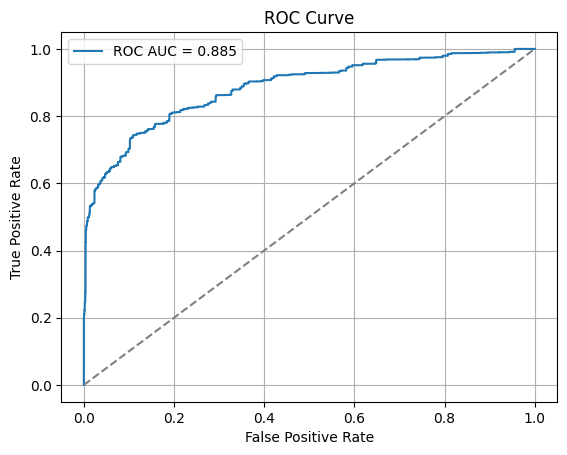

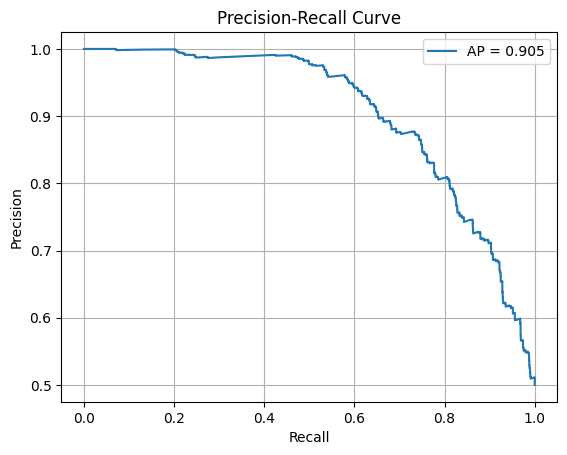

In [52]:
# Class predictions
y_pred = exported_pipeline.predict(X_test)

# If needed: decision function or probability scores
if hasattr(exported_pipeline[-1], "decision_function"):
    y_scores = exported_pipeline.decision_function(X_test)
elif hasattr(exported_pipeline[-1], "predict_proba"):
    y_scores = exported_pipeline.predict_proba(X_test)[:, 1]
    print(exported_pipeline) # only if available

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# PR curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap_score = average_precision_score(y_test, y_scores)

import matplotlib.pyplot as plt

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# PR Curve
plt.figure()
plt.plot(recall, precision, label=f"AP = {ap_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

# Recreate the logic without TPOT's custom StackingEstimator
rf = RandomForestClassifier(
    bootstrap=True, criterion="entropy", max_features=0.45,
    min_samples_leaf=3, min_samples_split=2, n_estimators=100, random_state=42
)

sgd = SGDClassifier(
    alpha=0.01, eta0=0.01, fit_intercept=False, l1_ratio=0.75,
    learning_rate="constant", loss="squared_hinge",
    penalty="elasticnet", power_t=0.5, random_state=42
)

# Manual stacking: fit RF, use its outputs as a feature
rf.fit(X_train, y_train)
rf_outputs = rf.predict_proba(X_train)[:, 1].reshape(-1, 1)  # or use rf.decision_function if needed

# Stack this with the original X_train
import numpy as np
X_train_stacked = np.hstack((X_train.values, rf_outputs))

# Normalize
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(norm='l1')
X_train_norm = normalizer.fit_transform(X_train_stacked)

# Fit final classifier
sgd.fit(X_train_norm, y_train)


SGDClassifier(alpha=0.01, eta0=0.01, fit_intercept=False, l1_ratio=0.75,
              learning_rate='constant', loss='squared_hinge',
              penalty='elasticnet', random_state=42)

In [38]:
# Predict with RF first
rf_test_outputs = rf.predict_proba(X_test)[:, 1].reshape(-1, 1)
X_test_stacked = np.hstack((X_test.values, rf_test_outputs))
X_test_norm = normalizer.transform(X_test_stacked)

y_pred = sgd.predict(X_test_norm)

In [39]:
y_scores = sgd.decision_function(X_test_norm)  

In [40]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# PR curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap_score = average_precision_score(y_test, y_scores)

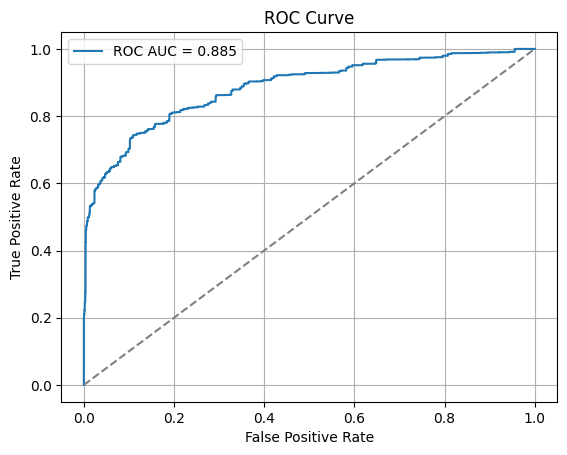

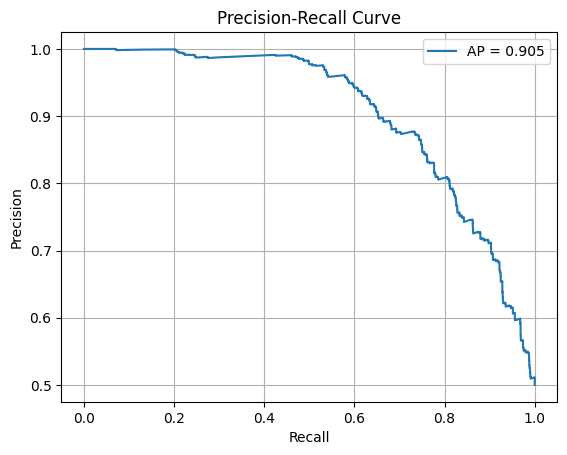

In [41]:
import matplotlib.pyplot as plt

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# PR Curve
plt.figure()
plt.plot(recall, precision, label=f"AP = {ap_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()
